# Feature Selection

Feature selection is a processing technique that aims to select only the most relevant features for prediction, while discarding redundant or inconsistent features. This is crucial especially for datasets with a large number of rows and/or a large number of features (particularly if $n_{\text{features}} \gg n_{\text{rows}}$), because more features means more computation and also potentially a higher chance of overfitting. Given two models with comparable predictive performance, we would prefer to take the simpler model as it is less likely to overfit to unseen data (lower variance). Feature selection is one such approach to reduce model complexity. The dataset here isn't terribly large but it can still be useful to do some feature importance analysis.

We already did a bit of semantic feature selection in the exploratory analysis (e.g. taking out long/lat as we already had location), but now we'll take a more mathematical approach - we will train a random forest classifier on the training data and rank features by their *mean decrease in impurity*.
- In a decision tree, the purity of a node measures how "mixed" the data points within a node are with respect to their classes. A node is 100% pure if all its data points belong to one class.
- One of the most common measures of purity is Gini impurity, which can be thought of as a measure of how well the decision tree's misclassification rate improves as compared to random labelling based on the distribution of labels in the data.
- Then the mean decrease in impurity for a given feature calculates how much the feature contributes to decreasing the impurity in each tree, weighted by the number of samples in each node, and then averaged across all the trees in the ensemble. The idea is that features that are more effective at distinguishing between classes will lead to large reductions in impurity when they are used to split nodes, and so are more important.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
sns.set()

We first load the training data and convert everything to numpy arrays so we have the familiar X predictors and y output. In total we have 1730 data points, and 31 features/predictors.

In [2]:
train = pd.read_csv("../data/thorax_and_wing_train.csv")
test = pd.read_csv("../data/thorax_and_wing_test.csv")

predictors = [c for c in train.columns if c != "Species"]

X_train, y_train = train[predictors].to_numpy(), train["Species"].to_numpy()
X_test, y_test = test[predictors].to_numpy(), test["Species"].to_numpy()

print("Train dataset:", X_train.shape, y_train.shape)
print("Test dataset:", X_test.shape, y_test.shape)

Train dataset: (1211, 31) (1211,)
Test dataset: (519, 31) (519,)


Now we'll rank feature importance as described above. We train a random forest classifier on the training set and access the feature importance via the `feature_importances_` attribute. We also plot the standard deviation of MDI across all the trees in the random forest.
- We can see that the variables corresponding to the thorax and wing measurements are the most important predictors for species type
- The replicate and vial variables do not seem to be very important - we could probably remove these
- While most of the population variables seem insignificant, "Binjour" seems to have some importance, so we'll just keep that one.
- Sex and temperature seem to be somewhat important, though not as much as the wing/thorax measurements. We'll keep these too

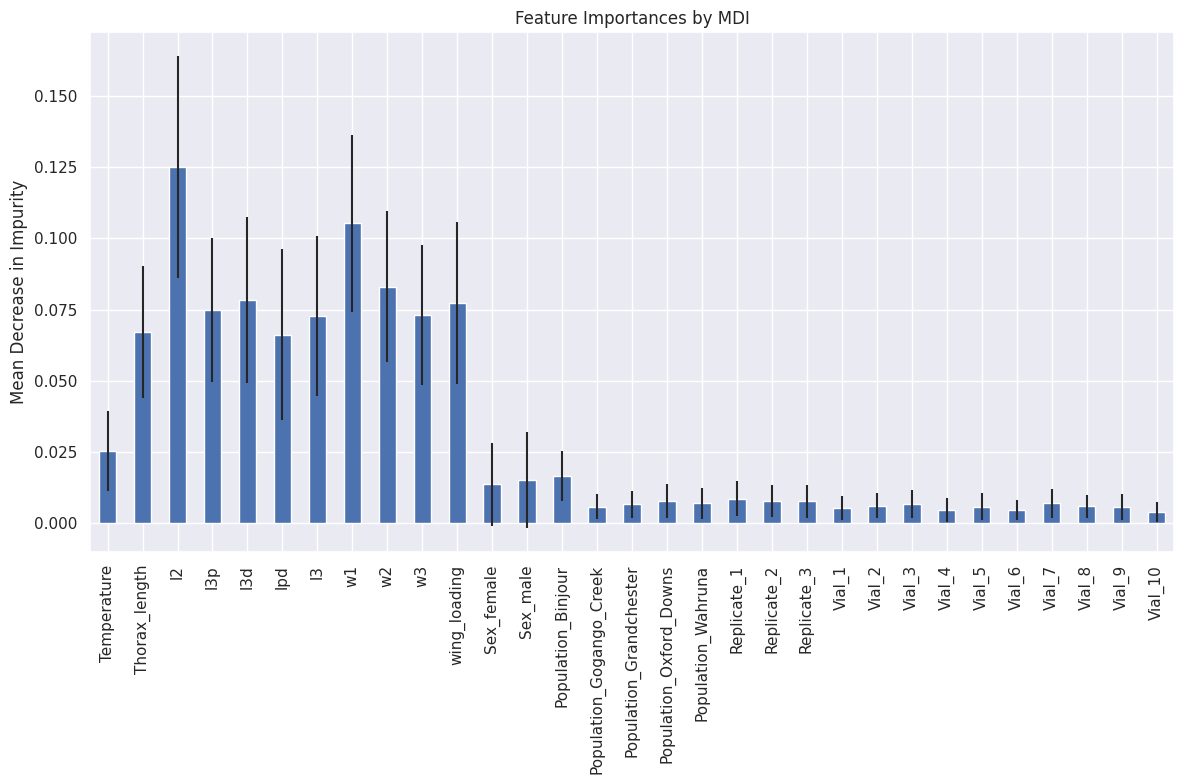

In [3]:
from sklearn.ensemble import RandomForestClassifier

fig, ax = plt.subplots(figsize=(12,8))

forest = RandomForestClassifier(random_state=42)
forest.fit(X_train, y_train)

importances = forest.feature_importances_
importances_std = np.std([tree.feature_importances_ for tree in forest.estimators_], axis=0)
forest_importances = pd.Series(importances, index=predictors)

forest_importances.plot.bar(yerr=importances_std, ax=ax)
ax.set_title("Feature Importances by MDI")
ax.set_ylabel("Mean Decrease in Impurity")
fig.tight_layout()
plt.savefig("../fig/mdi_feature_importances")

We'll drop the unimportant variables from both the training and test sets, so in total we end up with 14 columns (13 predictors).

In [4]:
cols_to_drop = (
    [c for c in train.columns if c.startswith("Replicate_")] +
    [c for c in train.columns if c.startswith("Vial_")] +
    [c for c in train.columns if c.startswith("Population_") and c != "Population_Binjour"] +
    ["Sex_male"]
)

train.drop(columns=cols_to_drop, inplace=True)
test.drop(columns=cols_to_drop, inplace=True)
print(train.shape, test.shape)
print(train.columns)

train.to_csv("../data/thorax_and_wing_mdi_train.csv")
test.to_csv("../data/thorax_and_wing_mdi_test.csv")

(1211, 14) (519, 14)
Index(['Species', 'Temperature', 'Thorax_length', 'l2', 'l3p', 'l3d', 'lpd',
       'l3', 'w1', 'w2', 'w3', 'wing_loading', 'Sex_female',
       'Population_Binjour'],
      dtype='object')
